In [2]:
import pandas as pd
import numpy as np


define loss functions

In [11]:
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def mse_grad(actual, predicted):
    return (predicted - actual)

Load Weather Data

In [12]:
# Read in our data, and fill missing values
data = pd.read_csv("test_data/clean_weather.csv", index_col=0)
data = data.ffill()
# Display a sequence of temperatures
data["tmax"].head(10)
# Turn our sequence into a single row of data
data["tmax"].head(10).to_numpy()[np.newaxis,:]

from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape

((9456, 3), (9456, 1), (2026, 3), (2026, 1), (2027, 3), (2027, 1))

Initalizing weights and biases

In [13]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

forward pass

In [14]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            # Activation.  tanh avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x

            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

backward pass

In [15]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

Run rnn

In [84]:
train_x[0], train_y[0]
train_x.shape, train_y.shape

((9456, 3), (9456, 1))

In [85]:
epochs = 50
lr = 1e-5

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)
predictions = []
valid_predictions = []
hidden_states = []  
for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)
        # Store hidden and predictions states visualization
        hidden_states.append(hiddens)
        predictions.append(outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)
            # Store valid predictions for visualization
            valid_predictions.append(outputs)
            

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 3122.594400144508 valid loss 2171.318686210202


same rnn but getting out predictions for each sequence

In [82]:
train_x.shape, train_y.shape

((9456, 3), (9456, 1))

Epoch: 1, Train Loss: 3124.9077, Valid Loss: 2178.8468
Epoch: 11, Train Loss: 84.8480, Valid Loss: 81.6229
Epoch: 21, Train Loss: 52.8808, Valid Loss: 52.4908
Epoch: 31, Train Loss: 34.9173, Valid Loss: 34.5494
Epoch: 41, Train Loss: 33.9319, Valid Loss: 33.9068
Epoch: 50, Train Loss: 31.0106, Valid Loss: 31.0893


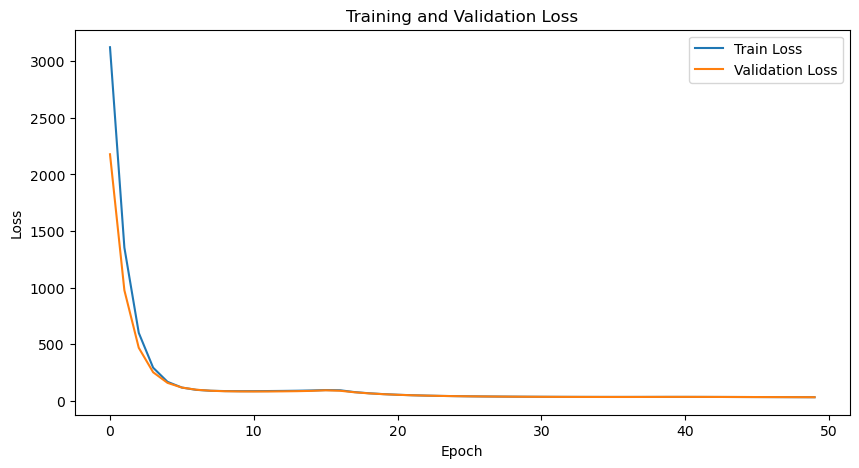

In [29]:
import matplotlib.pyplot as plt

epochs = 50
lr = 1e-5

layer_conf = [
    {"type": "input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)
predictions = []
valid_predictions = []

# Store losses for plotting
train_losses = []
valid_losses = []

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    epoch_valid_loss = 0
    train_preds = []
    valid_preds = []

    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        layers = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)
        train_preds.append(outputs)

    # Validation in each epoch
    for j in range(valid_x.shape[0] - sequence_len):
        seq_x = valid_x[j:(j+sequence_len),]
        seq_y = valid_y[j:(j+sequence_len),]
        _, outputs = forward(seq_x, layers)
        epoch_valid_loss += mse(seq_y, outputs)
        valid_preds.append(outputs)

    # Average losses for this epoch
    avg_train_loss = epoch_loss / (train_x.shape[0] - sequence_len)
    avg_valid_loss = epoch_valid_loss / (valid_x.shape[0] - sequence_len)
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

    # Store predictions for the last epoch
    if epoch == epochs - 1:
        predictions = train_preds
        valid_predictions = valid_preds

    # Printing loss info
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [77]:
predictions = np.array(predictions)
final_predictions = predictions[:, -1, 0]  # Assuming the last day's prediction is what corresponds to train_y
train_y.shape, predictions.shape
train_y[-7:], predictions[-1]
train_y.shape, predictions.shape, final_predictions.shape


((9456, 1), (9449, 7, 1), (9449,))

In [78]:
valid_predictions = np.array(valid_predictions)
final_valid_predictions = valid_predictions[:, -1, 0]
valid_y.shape, final_valid_predictions.shape

((2026, 1), (2019,))

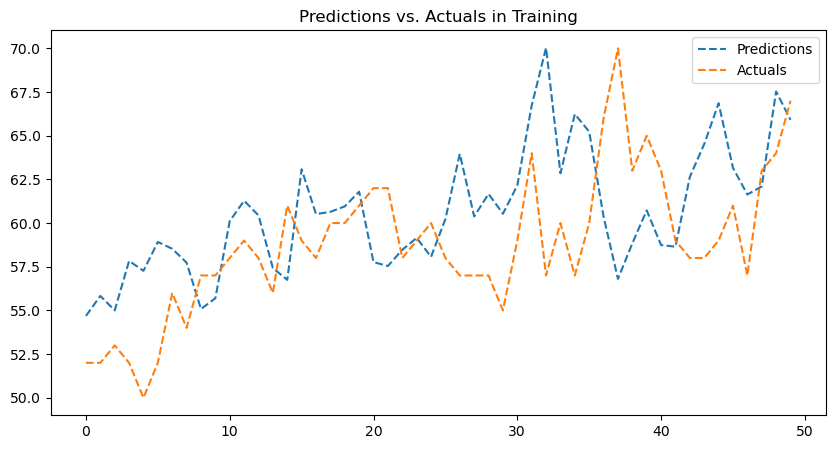

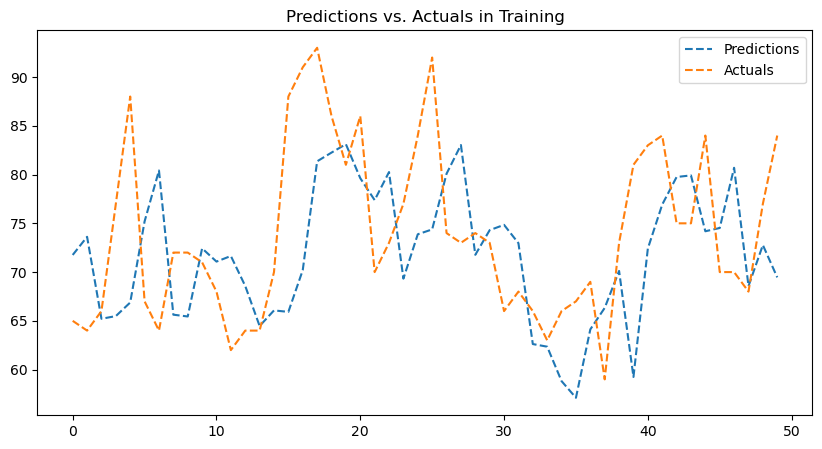

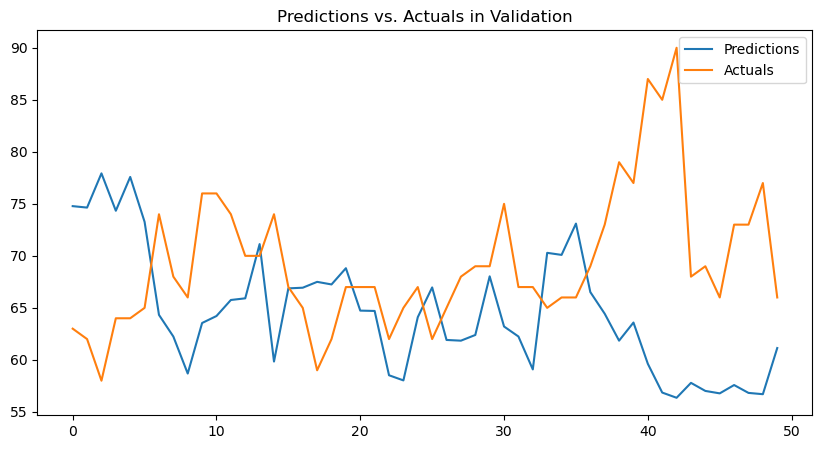

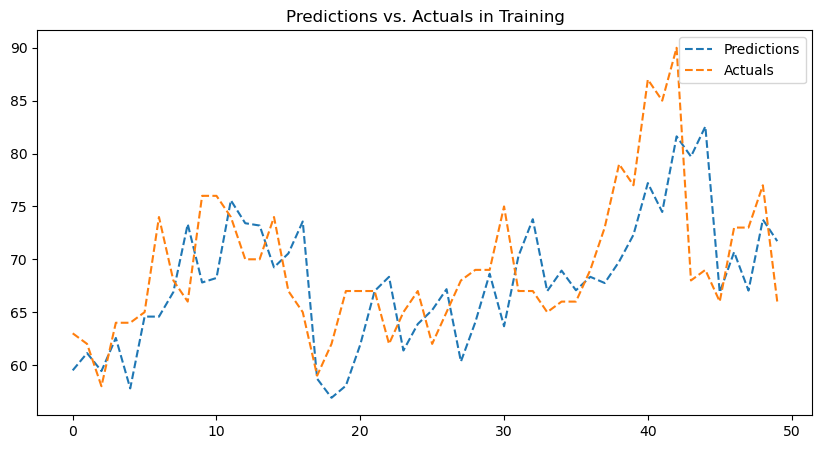

In [80]:
# Plotting example predictions vs. actuals for the last sequence in training
plt.figure(figsize=(10, 5))
plt.plot(final_predictions[0:50], label='Predictions', linestyle='--')
plt.plot(train_y[:,0][0:50], label='Actuals', linestyle='--')
plt.title('Predictions vs. Actuals in Training')
plt.legend()
plt.show()
# Plotting example predictions vs. actuals for the last sequence in training
plt.figure(figsize=(10, 5))
plt.plot(final_predictions[-50:], label='Predictions', linestyle='--')
plt.plot(train_y[:,0][-50:], label='Actuals', linestyle='--')
plt.title('Predictions vs. Actuals in Training')
plt.legend()
plt.show()

# Plotting example predictions vs. actuals for validation
plt.figure(figsize=(10, 5))
plt.plot(final_valid_predictions[0:50], label='Predictions')
plt.plot(valid_y[:,0][-50:], label='Actuals')
plt.title('Predictions vs. Actuals in Validation')
plt.legend()
plt.show()
# Plotting example predictions vs. actuals for the last sequence in training
plt.figure(figsize=(10, 5))
plt.plot(final_valid_predictions[-50:], label='Predictions', linestyle='--')
plt.plot(valid_y[:,0][-50:], label='Actuals', linestyle='--')
plt.title('Predictions vs. Actuals in Training')
plt.legend()
plt.show()

